In [3]:
!pip install onnx
!pip install onnxmltools skl2onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires p

# Import các thư viện sẽ sử dụng

In [13]:
import pandas as pd
import numpy as np
import onnx
import onnxruntime as ort
import joblib
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Phân tích dữ liệu và vẽ biểu đồ quan hệ

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4423 entries, 2025-01-27 14:18:58.474589+07:00 to 2025-02-02 19:09:13.290227+07:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   4423 non-null   float64
 1   Humidity      4423 non-null   float64
 2   SoilMoisture  4423 non-null   float64
 3   CoPpm         4423 non-null   float64
 4   LightLevel    4423 non-null   float64
 5   IsRaining     4423 non-null   float64
 6   Watering      4423 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 276.4 KB
None

Mô tả thống kê:
               count        mean        std         min         25%  \
Temperature   4423.0   20.367391   2.101005   16.000000   18.500000   
Humidity      4423.0   64.472168  14.582328   12.000000   50.099998   
SoilMoisture  4423.0   19.216595  21.319544    0.000000    8.000000   
CoPpm         4423.0  146.740669  18.175368  110.127451  126.392435 

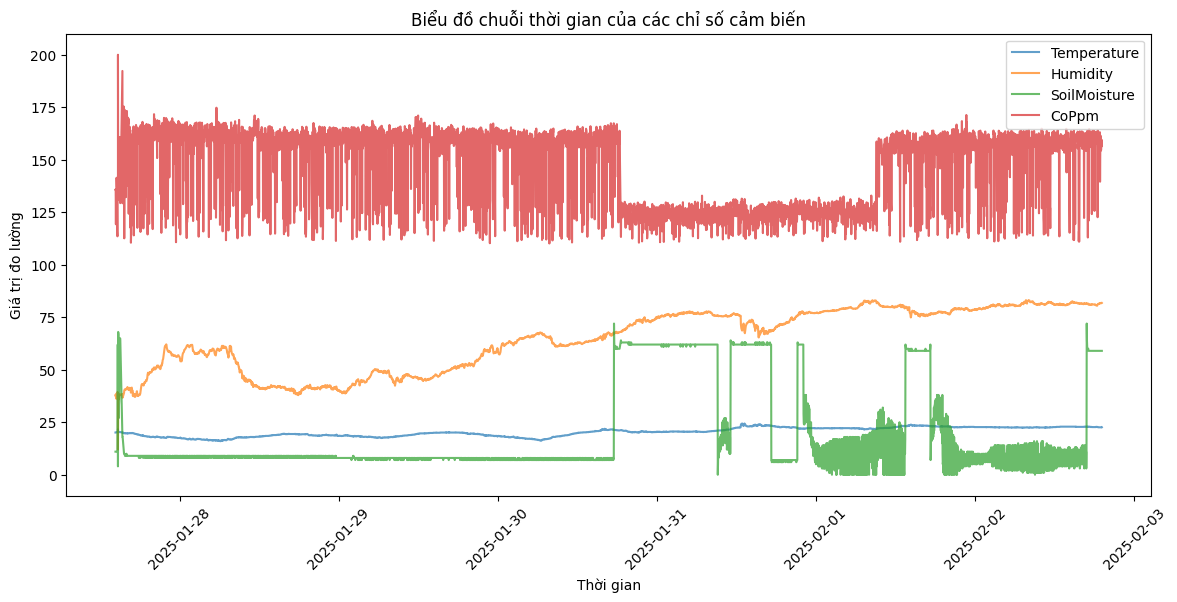


--------------------------Biến động của các chỉ số cảm biến theo thời gian (Độ lệch chuẩn)--------------------------



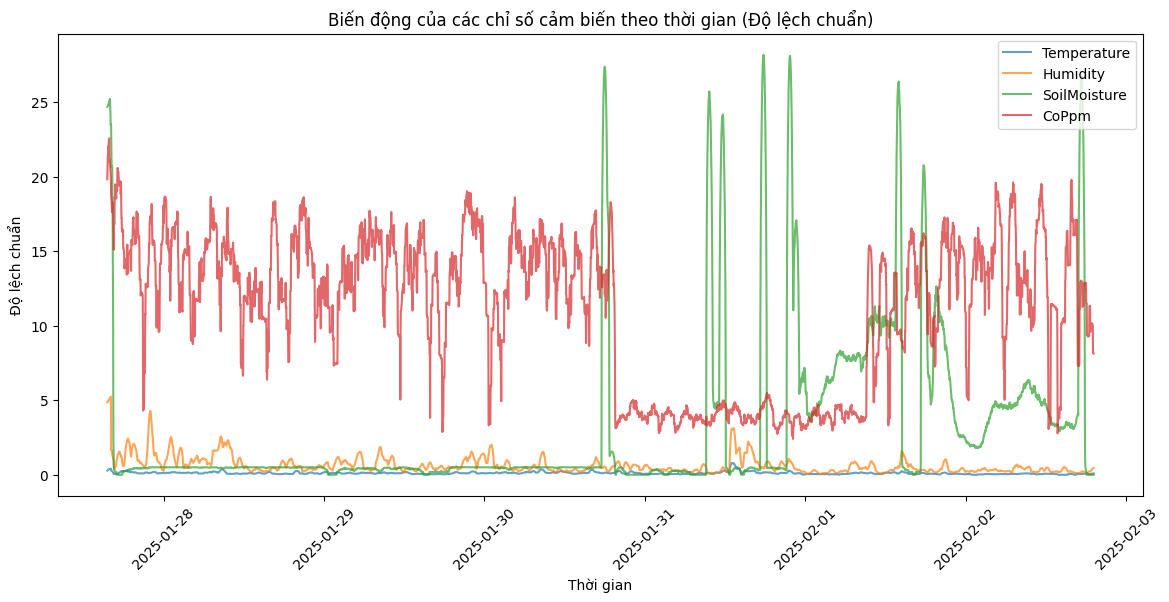


--------------------------Ma trận tương quan giữa các chỉ số cảm biến--------------------------



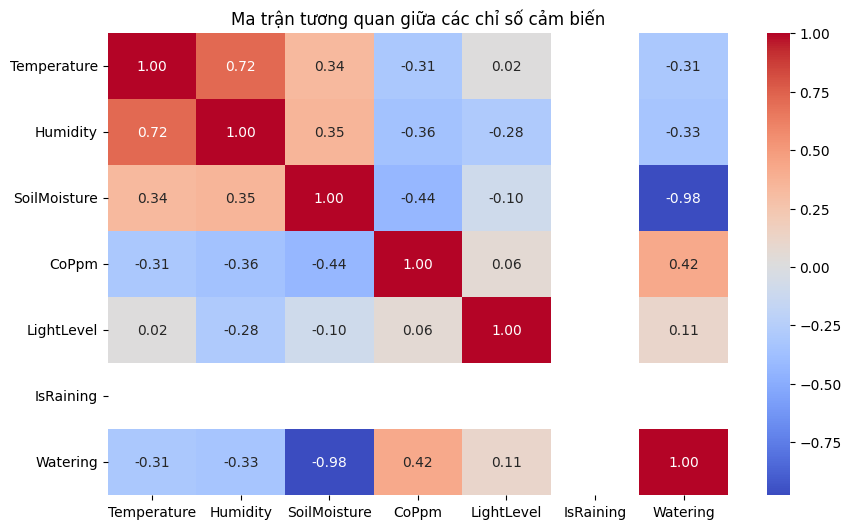


--------------------------Giá trị trung bình theo giờ--------------------------



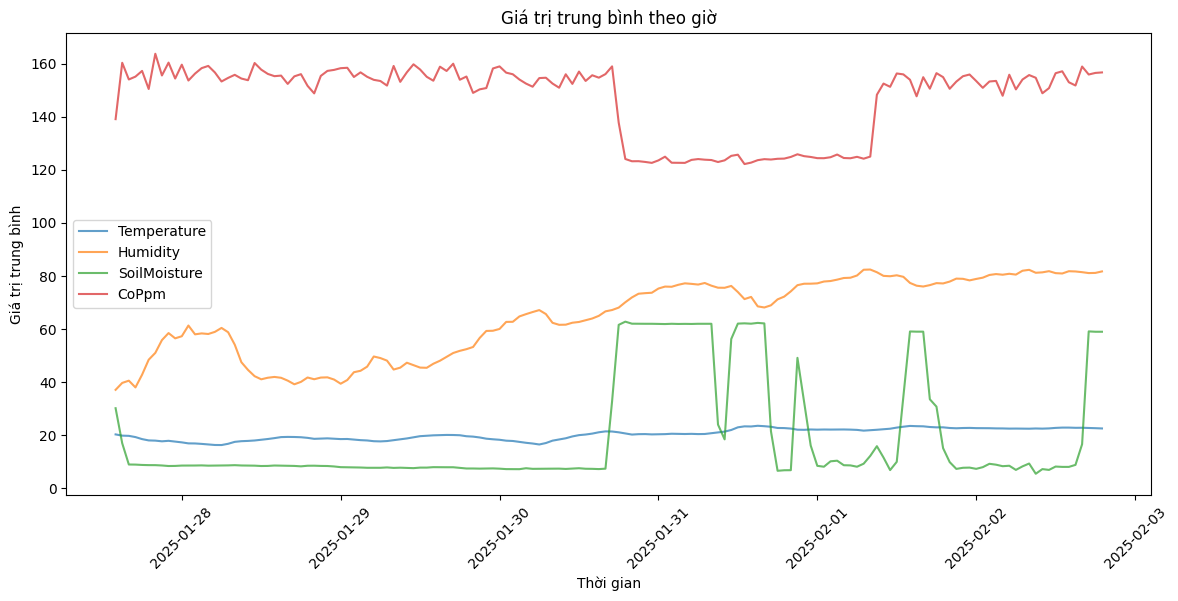

In [14]:
# Load dữ liệu
file_dataset = "garden_data_processed.csv"  # Đảm bảo file nằm trong thư mục làm việc

df = pd.read_csv(file_dataset)

# Chuyển đổi cột Timestamp thành datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# 1. Kiểm tra tổng quan dữ liệu
print("Thông tin dữ liệu:")
print(df.info())
print("\nMô tả thống kê:")
print(df.describe().T)
print("\nSố lượng giá trị thiếu:")
print(df.isnull().sum())

print("\n--------------------------Biểu đồ chuỗi thời gian của các chỉ số cảm biến--------------------------\n")
# 2. Vẽ biểu đồ chuỗi thời gian
plt.figure(figsize=(14, 6))
for col in df.columns[:4]:  # Chỉ vẽ 4 cột đầu tiên
    plt.plot(df.index, df[col], label=col, alpha=0.7)
plt.legend()
plt.title("Biểu đồ chuỗi thời gian của các chỉ số cảm biến")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị đo lường")
plt.xticks(rotation=45)
plt.show()

print("\n--------------------------Biến động của các chỉ số cảm biến theo thời gian (Độ lệch chuẩn)--------------------------\n")
# 3. Tính toán và vẽ độ lệch chuẩn theo thời gian
rolling_std = df.rolling(window=30).std()

plt.figure(figsize=(14, 6))
for col in df.columns[:4]:
    plt.plot(df.index, rolling_std[col], label=col, alpha=0.7)
plt.legend()
plt.title("Biến động của các chỉ số cảm biến theo thời gian (Độ lệch chuẩn)")
plt.xlabel("Thời gian")
plt.ylabel("Độ lệch chuẩn")
plt.xticks(rotation=45)
plt.show()

print("\n--------------------------Ma trận tương quan giữa các chỉ số cảm biến--------------------------\n")
# 4. Phân tích tương quan giữa các biến
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Ma trận tương quan giữa các chỉ số cảm biến")
plt.show()

print("\n--------------------------Giá trị trung bình theo giờ--------------------------\n")
# 5. Kiểm tra tính chu kỳ bằng cách vẽ trung bình theo giờ
hourly_avg = df.resample('h').mean()
plt.figure(figsize=(14, 6))
for col in df.columns[:4]:
    plt.plot(hourly_avg.index, hourly_avg[col], label=col, alpha=0.7)
plt.legend()
plt.title("Giá trị trung bình theo giờ")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị trung bình")
plt.xticks(rotation=45)
plt.show()

# Triển khai huấn luyện mô hình bằng Random Forest

In [2]:
# Đọc dữ liệu
data_path = "garden_data_processed.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

In [3]:
# Chọn đặc trưng đầu vào và nhãn
target = "Watering"
features = ["Temperature", "Humidity", "SoilMoisture", "CoPpm", "LightLevel", "IsRaining"]

X = df[features]
y = df[target]

In [4]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Khởi tạo và huấn luyện mô hình
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác: {accuracy:.4f}")
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác: 1.0000
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       707

    accuracy                           1.00       885
   macro avg       1.00      1.00      1.00       885
weighted avg       1.00      1.00      1.00       885



In [8]:
# Chuyển đổi mô hình sang ONNX
initial_type = [("input", FloatTensorType([None, len(features)]))]
onnx_model = convert_sklearn(model, initial_types=initial_type)
onnx_path = "random_forest_watering.onnx"
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())
print(f"Mô hình đã được lưu tại: {onnx_path}")

Mô hình đã được lưu tại: random_forest_watering.onnx


In [ ]:
# Tạo đầu vào thử nghiệm
# với các giá trị trong mảng lần lượt đại diện cho : 
# ["Temperature", "Humidity", "SoilMoisture", "CoPpm", "LightLevel", "IsRaining"]
sample_input = np.array([[20.5, 65, 10, 150, 5, 0]], dtype=np.float32) 

# Dự đoán bằng mô hình ONNX
ort_session = ort.InferenceSession(onnx_path)
input_name = ort_session.get_inputs()[0].name
pred_onnx = ort_session.run(None, {input_name: sample_input})
print(f"Dự đoán của mô hình ONNX: {pred_onnx[0]}")

Dự đoán của mô hình ONNX: [1]
